In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v6 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-22 02:55:16.748732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 02:55:16.749333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 02:55:16.806473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 02:55:16.806830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 02:55:16.807032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_038
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

In [15]:
# plot(
#     boundary_idx_arr,
#     delta_t,
#     all_data,
#     xgrid,
#     xticks_snapto=int(40*np.round((T//10)/40))
# )

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

In [17]:
# plot(
#     boundary_idx_arr,
#     delta_t,
#     all_data,
#     xgrid,
#     xticks_snapto=int(40*np.round((T//10)/40))
# )

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

In [21]:
# plot_latent_states_KS(
#     boundary_idx_arr,
#     latent_states_all,
#     delta_t,
#     dir_name_ae,
#     xticks_snapto=int(40*np.round((T//10)/40)),
#     num_yticks=11,
#     save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.2
    num_input_tsteps = 10000
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [num_latent_states*200]
    stateful = True
    omega_in = [1.0]
    degree_of_connectivity = [3]
    rho_res = [0.6]
    usebias_Win = [False]
    alpha = [0.99]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'linear'
    use_weights_post_dense = False
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
time_mean = np.mean(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    epochs = 20
    lambda_reg = 1e-4 # weight for regularizer
    min_delta = 1e-6
    patience = epochs# 5
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 1
    fRMS = 1/100
    use_best = False

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'epochs':epochs,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'lambda_reg':lambda_reg,
        'min_delta':min_delta,
        'patience':patience,
        'use_best':use_best,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    epochs = tparams_dict['epochs']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    lambda_reg = tparams_dict['lambda_reg']
    min_delta = tparams_dict['min_delta']
    patience = tparams_dict['patience']
    try:
        use_best = tparams_dict['use_best']
    except:
        print("'use_best' not present in 'training_specific_params', set to True.")
        use_best = True

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (19, 10000, 16)
 testing_data_rnn_input.shape :  (3, 10000, 16)
     val_data_rnn_input.shape :  (2, 10000, 16)


In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        ESN_layers_units=ESN_layers_units,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        sparsity=sparsity,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        use_weights_post_dense=use_weights_post_dense,
        activation_post_Wout=activation_post_Wout,
        scalar_weights=[],
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(1,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.003306623697280884


In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
# elif behaviour == 'loadCheckpointAndContinueTraining':
#     val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
#         dir_name_ae=dir_name_rnn,
#         dir_sep=dir_sep,
#         epochs=epochs,
#         learning_rate_list=learning_rate_list,
#         return_earlystopping_wait=True)
#     savelosses_cb_vallossarr = val_loss_arr_fromckpt
#     savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [32]:
@tf.function
def batched_computation(
        num_batches,
        rnn_net,
        training_data_rnn_input,
        training_data_rnn_output,
        usebias_Wout,
        Hb, Yb,
        hidden_units, output_units,
        lambda_reg, eye_Hb,
):
    Hb = np.zeros(shape=(hidden_units, hidden_units), dtype=np.float32)
    Yb = np.zeros(shape=(output_units, hidden_units), dtype=np.float32)
    
    if usebias_Wout == True:
        Hb_col = np.zeros(shape=(1, hidden_units), dtype=np.float32)
        Hb_row = np.zeros(shape=(1, hidden_units), dtype=np.float32)
        # Hb_lelem = np.zeros(shape=[1, 1], dtype=np.float32)
        Yb_col = np.zeros(shape=(1, output_units), dtype=np.float32)
    for j in range(num_batches):
        # h = np.array(rnn_net(training_data_rnn_input[j:j+1], training=True))
        h = rnn_net(training_data_rnn_input[j:j+1], training=True)
        # print(h.shape)
        h = h[0]
        # y = tf.constant(training_data_rnn_output[j])
        y = training_data_rnn_output[j]
        # if usebias_Wout == True:
        #     h = np.concatenate((h, np.ones(shape=(h.shape[0], 1))), axis=1)
        # Hb[0:hidden_units, 0:hidden_units] += tf.linalg.matmul(tf.transpose(h), h)
        Hb = tf.math.add(Hb, tf.linalg.matmul(tf.transpose(h), h))
        if usebias_Wout == True:
            # for k in range(hidden_units):
            #     Hb[k, -1] += tf.math.reduce_sum(h[:, k])
            #     Hb[-1, k] += Hb[k, -1]
            # Hb[-1, -1] += h.shape[0]
            Hb_col = tf.math.add(Hb_col, tf.math.reduce_sum(h, axis=0))
            Hb_row = tf.math.add(Hb_row, tf.math.reduce_sum(h, axis=0))

        # Yb[:, 0:hidden_units] += tf.linalg.matmul(tf.transpose(y), h)
        Yb = tf.math.add(Yb, tf.linalg.matmul(tf.transpose(y), h))
        if usebias_Wout == True:
            # for k in range(output_units):
            #     Yb[k, -1] += tf.math.reduce_sum(y[:, k])
            Yb_col = tf.math.add(Yb_col, tf.math.reduce_sum(y, axis=0))
        # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
        # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)
    
    if usebias_Wout == True:
        Hb = tf.concat([Hb, tf.reshape(Hb_col, shape=(hidden_units, 1))], axis=1)
        Hb_row = tf.concat([Hb_row, tf.constant([[float(training_data_rnn_input.shape[0]*training_data_rnn_input.shape[1])]])], axis=1)
        Hb = tf.concat([Hb, Hb_row], axis=0)

        Yb = tf.concat([Yb, tf.reshape(Yb_col, shape=(output_units, 1))], axis=1)
    
    Wout = tf.linalg.matmul(
        Yb,
        tf.linalg.inv(Hb + lambda_reg*eye_Hb)
    )
    Wout = tf.transpose(Wout)
    return Wout


@tf.function
def compute_mse(
        data_input,
        data_output,
        rnn_net):

    mse = 0.
    for j in range(data_input.shape[0]):
        # pred = np.array(rnn_net(data_input[j:j+1], training=False))
        pred = rnn_net(data_input[j:j+1], training=False)
        temp = (pred - data_output[j:j+1])**2
        temp = tf.math.reduce_mean(temp, axis=-1) # do a sqrt here to get rmse
        temp = tf.math.reduce_mean(temp, axis=-1)
        temp = tf.math.reduce_mean(temp, axis=-1)
        mse = mse*j/(j+1) + temp*1/(j+1)
        
    return mse

In [33]:
def invert_fn(y):
    # post_Wout_activation = 'linear'
    return y

# def invert_fn(y):
#     # post_Wout_activation = 'tanh'
#     y = np.where(y < 1.0, y, 1-1e-6)
#     y = np.where(y > -1.0, y, -1+1e-6)
#     y = 0.5*(np.log(1+y) - np.log(1-y))
#     return y
    

In [34]:
training_data_rnn_input.dtype

dtype('float32')

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    metrics=['mse'],
    run_eagerly=False
)

lambda_reg = float(lambda_reg)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    rnn_net.load_weights(wt_file)
    
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':

    Wout_best = 0
    val_mse_best = np.inf
    Wout_candidate = 0
    wait = 0
    if use_weights_post_dense == True:
        postWout_candidate = 0
        h_activation = tf.keras.activations.get(activation_post_Wout)
    
    
    hidden_units = ESN_layers_units[-1]
    output_units = rnn_net.data_dim
    
    Hb_shape = [hidden_units, hidden_units]
    Yb_shape = [output_units, hidden_units]
    if usebias_Wout == True:
        Hb_shape[0] += 1
        Hb_shape[1] += 1
        Yb_shape[1] += 1
        
    Hb = np.zeros(shape=Hb_shape, dtype=FTYPE)
    Yb = np.zeros(shape=Yb_shape, dtype=FTYPE)
    eye_Hb = np.eye(Hb.shape[0], dtype=FTYPE)

    num_batches = training_data_rnn_input.shape[0]
    
    
    for i in range(epochs):
        # for layer in rnn_net.ESN_layers:
        #     layer.reset_states()

        epoch_totaltime = time.time()

        total_s_len = 80
        sep_lr_s = ' EPOCH : {} '.format(i+1)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')

        # '''
        ### computing Wout
        Hb[:, :] = 0
        Yb[:, :] = 0
        epoch_time = time.time()
        avg_time = 0.
        num_runs = training_data_rnn_input.shape[0]
        for j in range(num_runs):
            batch_time = time.time()
            h = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=True))
            # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
            # print(h.shape)
            h = h[0]
            # y = tf.constant(training_data_rnn_output[j])
            y = invert_fn(training_data_rnn_output[j])
            if usebias_Wout == True:
                h = np.concatenate((h, np.ones(shape=(h.shape[0], 1))), axis=1)
            Hb = Hb + np.matmul(np.transpose(h), h)
            Yb = Yb + np.matmul(np.transpose(y), h)
            # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
            # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)
            batch_time = time.time() - batch_time
            avg_time = (avg_time*j + batch_time)/(j+1)
            eta = avg_time * (num_runs-1 - j)
            print('{} / {} -- Wout batch_time : {:.2f} s -- eta : {:.0f}h {:.0f}m {:.0f}s'.format(
                j+1,
                num_runs,
                batch_time,
                float(eta // 3600),
                float((eta%3600)//60),
                float((eta%3600)%60),
            ))

        Wout = np.matmul(
            Yb,
            np.linalg.inv(Hb + lambda_reg*np.eye(Hb.shape[0]))
        )
        Wout = np.transpose(Wout)
        # Wout = tf.linalg.matmul(
        #     Yb,
        #     tf.linalg.inv(Hb + lambda_reg*tf.eye(Hb.shape[0]))
        # )
        # Wout = tf.transpose(Wout)
        
        if use_weights_post_dense == True:
            ### computing postWout
            HYb = 0
            HHb = 0
            for j in range(training_data_rnn_input.shape[0]):
                batch_time = time.time()
                h = np.array(rnn_net(training_data_rnn_input[j:j+1], training=True))
                # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
                # print(h.shape)
                h = h[0]
                h = np.matmul(h, Wout[0:ESN_layers_units[-1], :])
                if usebias_Wout == True:
                    h = h + Wout[ESN_layers_units[-1]:, :]
                # y = tf.constant(training_data_rnn_output[j])
                h = np.array(h_activation(h))
                y = training_data_rnn_output[j]
                HYb = HYb + np.sum(h*y, axis=0)
                HHb = HHb + np.sum(h**2, axis=0)
                # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
                # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)

                print('{} / {} -- postWout batch_time : {} sec'.format(
                    j+1,
                    training_data_rnn_input.shape[0],
                    time.time() - batch_time
                ))
                
            postWout = HYb / (HHb + lambda_reg)

        print('\nepoch_time : {} sec'.format(time.time() - epoch_time))
        
        '''
        epoch_time = time.time()
        Wout = batched_computation(
            num_batches,
            rnn_net,
            training_data_rnn_input,
            training_data_rnn_output,
            usebias_Wout,
            Hb, Yb,
            hidden_units, output_units,
            lambda_reg, eye_Hb)
        print('\nepoch_time : {} sec'.format(time.time() - epoch_time))

        Hb[:, :] = 0.0
        Yb[:, :] = 0.0
        '''
    
        Wout_candidate = Wout_candidate*i/(i+1) + Wout*1/(i+1)
        tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_candidate[0:ESN_layers_units[-1], :])
        if usebias_Wout == True:
            tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_candidate[-1, :])

        if use_weights_post_dense == True:
            postWout_candidate = postWout_candidate*i/(i+1) + postWout*1/(i+1)
            tf.keras.backend.set_value(rnn_net.postWout.individual_weights, postWout_candidate)

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

        print('\nval mse')
        # '''
        val_mse = 0
        for j in range(val_data_rnn_input.shape[0]):
            batch_time = time.time()
            val_pred = np.array(rnn_net(val_data_rnn_input[j:j+1], training=False))
            temp = (val_pred - val_data_rnn_output[j:j+1])**2
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            val_mse = val_mse*j/(j+1) + temp*1/(j+1)
            print('{} / {} -- batch_time : {} sec'.format(
                j+1,
                val_data_rnn_input.shape[0],
                time.time() - batch_time
            ))
        '''
        mse_time = time.time()
        val_mse = compute_mse(
            val_data_rnn_input,
            val_data_rnn_output,
            rnn_net)
        mse_time = time.time() - mse_time
        print('val_mse compute time : {} sec'.format(mse_time))
        '''

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

        print('\ntraining mse')
        # '''
        train_mse = 0
        for j in range(training_data_rnn_input.shape[0]):
            batch_time = time.time()
            train_pred = np.array(rnn_net(training_data_rnn_input[j:j+1], training=False))
            temp = (train_pred - training_data_rnn_output[j:j+1])**2
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            train_mse = train_mse*j/(j+1) + temp*1/(j+1)
            print('{} / {} -- batch_time : {} sec'.format(
                j+1,
                training_data_rnn_input.shape[0],
                time.time() - batch_time
            ))
        '''
        mse_time = time.time()
        train_mse = compute_mse(
            training_data_rnn_input,
            training_data_rnn_output,
            rnn_net)
        mse_time = time.time() - mse_time
        print('train_mse compute time : {} sec'.format(mse_time))
        '''

        for layer in rnn_net.ESN_layers:
            layer.reset_states()

#         print('\ntesting mse')
#         test_mse = 0
#         for j in range(testing_data_rnn_input.shape[0]):
#             print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
#             test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
#             temp = (test_pred - testing_data_rnn_output[j:j+1])**2
#             temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
#             temp = np.mean(temp, axis=-1)
#             temp = np.mean(temp, axis=-1)
#             test_mse = test_mse*j/(j+1) + temp*1/(j+1)
        
#         for layer in rnn_net.ESN_layers:
#             layer.reset_states()

        val_loss_hist.append(val_mse)
        train_loss_hist.append(train_mse)
        
        # print('\ntest_mse : {}'.format(test_mse))
        print('\ntrain_mse : {}'.format(train_mse))
        print('val_mse : {}'.format(val_mse))
        if val_mse + min_delta <= val_mse_best:
            print('val_mse improved from {}'.format(val_mse_best))
            Wout_best = Wout_candidate
            val_mse_best = val_mse
            wait = 0
        else:
            wait += 1
            print('val_mse did not improve from {}, wait : {}'.format(val_mse_best, wait))

        print('\nTotal epoch computation time : {} sec'.format(time.time()-epoch_totaltime))
            
        if wait >= patience:
            print('\nearly stopping')
            break
        
#         val_loss_hist.extend(history.history['val_loss'])
#         train_loss_hist.extend(history.history['loss'])
        
#         if i == starting_lr_idx:
#             lr_change[i+1] += len(history.history['val_loss'])
#         else:
#             lr_change.append(lr_change[i]+len(history.history['val_loss']))

# tf.keras.backend.set_value(rnn_net.Wout, Wout_best)

if use_best == True:
    tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_best[0:ESN_layers_units[-1], :])
    if usebias_Wout == True:
        tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_best[-1, :])
print('\ntest mse')
test_mse = 0
for j in range(testing_data_rnn_input.shape[0]):
    print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
    test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
    temp = (test_pred - testing_data_rnn_output[j:j+1])**2
    temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
    temp = np.mean(temp, axis=-1)
    temp = np.mean(temp, axis=-1)
    test_mse = test_mse*j/(j+1) + temp*1/(j+1)
print('test_mse : {}'.format(test_mse))

for layer in rnn_net.ESN_layers:
    layer.reset_states()



--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 19 -- Wout batch_time : 3.39 s -- eta : 0h 1m 1s
2 / 19 -- Wout batch_time : 2.94 s -- eta : 0h 0m 54s
3 / 19 -- Wout batch_time : 3.23 s -- eta : 0h 0m 51s
4 / 19 -- Wout batch_time : 3.24 s -- eta : 0h 0m 48s
5 / 19 -- Wout batch_time : 3.39 s -- eta : 0h 0m 45s
6 / 19 -- Wout batch_time : 2.90 s -- eta : 0h 0m 41s
7 / 19 -- Wout batch_time : 2.81 s -- eta : 0h 0m 38s
8 / 19 -- Wout batch_time : 3.15 s -- eta : 0h 0m 34s
9 / 19 -- Wout batch_time : 2.94 s -- eta : 0h 0m 31s
10 / 19 -- Wout batch_time : 3.05 s -- eta : 0h 0m 28s
11 / 19 -- Wout batch_time : 3.00 s -- eta : 0h 0m 25s
12 / 19 -- Wout batch_time : 3.03 s -- eta : 0h 0m 22s
13 / 19 -- Wout batch_time : 2.92 s -- eta : 0h 0m 18s
14 / 19 -- Wout batch_time : 3.03 s -- eta : 0

11 / 19 -- Wout batch_time : 3.13 s -- eta : 0h 0m 25s
12 / 19 -- Wout batch_time : 3.10 s -- eta : 0h 0m 21s
13 / 19 -- Wout batch_time : 2.59 s -- eta : 0h 0m 18s
14 / 19 -- Wout batch_time : 3.15 s -- eta : 0h 0m 15s
15 / 19 -- Wout batch_time : 2.85 s -- eta : 0h 0m 12s
16 / 19 -- Wout batch_time : 2.98 s -- eta : 0h 0m 9s
17 / 19 -- Wout batch_time : 3.13 s -- eta : 0h 0m 6s
18 / 19 -- Wout batch_time : 3.04 s -- eta : 0h 0m 3s
19 / 19 -- Wout batch_time : 2.94 s -- eta : 0h 0m 0s

epoch_time : 59.34301471710205 sec

val mse
1 / 2 -- batch_time : 1.3890981674194336 sec
2 / 2 -- batch_time : 1.3748488426208496 sec

training mse
1 / 19 -- batch_time : 1.3129522800445557 sec
2 / 19 -- batch_time : 1.4457876682281494 sec
3 / 19 -- batch_time : 1.4508023262023926 sec
4 / 19 -- batch_time : 1.4113943576812744 sec
5 / 19 -- batch_time : 1.3913846015930176 sec
6 / 19 -- batch_time : 1.2881855964660645 sec
7 / 19 -- batch_time : 1.3231391906738281 sec
8 / 19 -- batch_time : 1.2015774250030

3 / 19 -- batch_time : 1.3130419254302979 sec
4 / 19 -- batch_time : 1.2949111461639404 sec
5 / 19 -- batch_time : 1.3826680183410645 sec
6 / 19 -- batch_time : 1.2501680850982666 sec
7 / 19 -- batch_time : 1.3382887840270996 sec
8 / 19 -- batch_time : 1.2689154148101807 sec
9 / 19 -- batch_time : 1.3700664043426514 sec
10 / 19 -- batch_time : 1.3056159019470215 sec
11 / 19 -- batch_time : 1.3344848155975342 sec
12 / 19 -- batch_time : 1.2674975395202637 sec
13 / 19 -- batch_time : 1.332662582397461 sec
14 / 19 -- batch_time : 1.5992140769958496 sec
15 / 19 -- batch_time : 1.2728371620178223 sec
16 / 19 -- batch_time : 1.361666202545166 sec
17 / 19 -- batch_time : 1.4050171375274658 sec
18 / 19 -- batch_time : 1.3004319667816162 sec
19 / 19 -- batch_time : 1.3591649532318115 sec

train_mse : 3.2386928499985708e-06
val_mse : 6.06196363150957e-06
val_mse did not improve from 6.2095991779642645e-06, wait : 6

Total epoch computation time : 86.36244225502014 sec


-------------------------

19 / 19 -- batch_time : 1.4042539596557617 sec

train_mse : 3.231233198388701e-06
val_mse : 6.048734803698608e-06
val_mse did not improve from 6.2095991779642645e-06, wait : 9

Total epoch computation time : 86.73303198814392 sec


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 11 ----------------------------------

--------------------------------------------------------------------------------


1 / 19 -- Wout batch_time : 2.83 s -- eta : 0h 0m 51s
2 / 19 -- Wout batch_time : 3.07 s -- eta : 0h 0m 50s
3 / 19 -- Wout batch_time : 2.88 s -- eta : 0h 0m 47s
4 / 19 -- Wout batch_time : 2.52 s -- eta : 0h 0m 42s
5 / 19 -- Wout batch_time : 2.83 s -- eta : 0h 0m 40s
6 / 19 -- Wout batch_time : 2.97 s -- eta : 0h 0m 37s
7 / 19 -- Wout batch_time : 3.08 s -- eta : 0h 0m 35s
8 / 19 -- Wout batch_time : 2.86 s -- eta : 0h 0m 32s
9 / 19 -- Wout batch_time : 2.93 s -- eta : 0h 0m 29s
10 / 19 -- Wout batch_time : 2.97 s

6 / 19 -- Wout batch_time : 2.88 s -- eta : 0h 0m 37s
7 / 19 -- Wout batch_time : 3.01 s -- eta : 0h 0m 35s
8 / 19 -- Wout batch_time : 2.94 s -- eta : 0h 0m 32s
9 / 19 -- Wout batch_time : 3.02 s -- eta : 0h 0m 29s
10 / 19 -- Wout batch_time : 2.88 s -- eta : 0h 0m 26s
11 / 19 -- Wout batch_time : 2.76 s -- eta : 0h 0m 23s
12 / 19 -- Wout batch_time : 3.13 s -- eta : 0h 0m 20s
13 / 19 -- Wout batch_time : 2.96 s -- eta : 0h 0m 17s
14 / 19 -- Wout batch_time : 3.11 s -- eta : 0h 0m 15s
15 / 19 -- Wout batch_time : 2.72 s -- eta : 0h 0m 12s
16 / 19 -- Wout batch_time : 2.81 s -- eta : 0h 0m 9s
17 / 19 -- Wout batch_time : 2.93 s -- eta : 0h 0m 6s
18 / 19 -- Wout batch_time : 2.94 s -- eta : 0h 0m 3s
19 / 19 -- Wout batch_time : 2.98 s -- eta : 0h 0m 0s

epoch_time : 57.5044310092926 sec

val mse
1 / 2 -- batch_time : 1.277355432510376 sec
2 / 2 -- batch_time : 1.426530122756958 sec

training mse
1 / 19 -- batch_time : 1.213923454284668 sec
2 / 19 -- batch_time : 1.4826431274414062 sec
3


epoch_time : 56.51448702812195 sec

val mse
1 / 2 -- batch_time : 1.3386869430541992 sec
2 / 2 -- batch_time : 1.4038643836975098 sec

training mse
1 / 19 -- batch_time : 1.3568699359893799 sec
2 / 19 -- batch_time : 1.4067096710205078 sec
3 / 19 -- batch_time : 1.313213586807251 sec
4 / 19 -- batch_time : 1.3039286136627197 sec
5 / 19 -- batch_time : 1.4299843311309814 sec
6 / 19 -- batch_time : 1.2959842681884766 sec
7 / 19 -- batch_time : 1.3563692569732666 sec
8 / 19 -- batch_time : 1.3097648620605469 sec
9 / 19 -- batch_time : 1.3019330501556396 sec
10 / 19 -- batch_time : 1.4646272659301758 sec
11 / 19 -- batch_time : 1.2905032634735107 sec
12 / 19 -- batch_time : 1.3738839626312256 sec
13 / 19 -- batch_time : 1.2937815189361572 sec
14 / 19 -- batch_time : 1.3185219764709473 sec
15 / 19 -- batch_time : 1.2703819274902344 sec
16 / 19 -- batch_time : 1.3132421970367432 sec
17 / 19 -- batch_time : 1.3508999347686768 sec
18 / 19 -- batch_time : 1.4288403987884521 sec
19 / 19 -- batc

14 / 19 -- batch_time : 1.372178077697754 sec
15 / 19 -- batch_time : 1.4647037982940674 sec
16 / 19 -- batch_time : 1.365190029144287 sec
17 / 19 -- batch_time : 1.3281941413879395 sec
18 / 19 -- batch_time : 1.3723347187042236 sec
19 / 19 -- batch_time : 1.257080078125 sec

train_mse : 3.223000595952678e-06
val_mse : 6.040273319740663e-06
val_mse did not improve from 6.2095991779642645e-06, wait : 19

Total epoch computation time : 86.89676189422607 sec

test mse
1 / 3
2 / 3
3 / 3
test_mse : 5.4494368365946375e-06


In [36]:
# if use_weights_post_dense == True:
    

In [37]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
#     test_loss = rnn_net.evaluate(
#         testing_data_rnn_input, testing_data_rnn_output,
#     )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
#             'lr_change':lr_change,
            'test_loss':test_mse
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

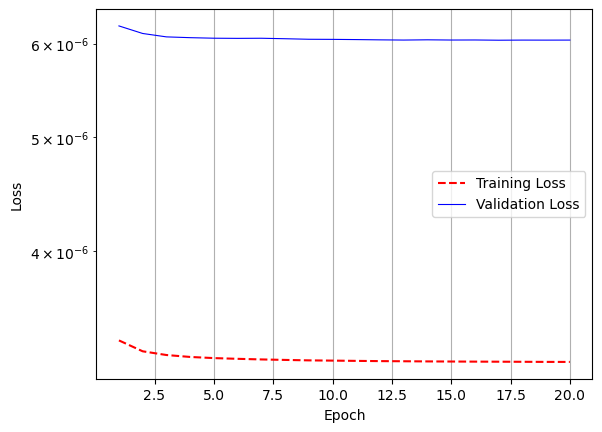

In [38]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=None,
    learning_rate_list=None
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 0


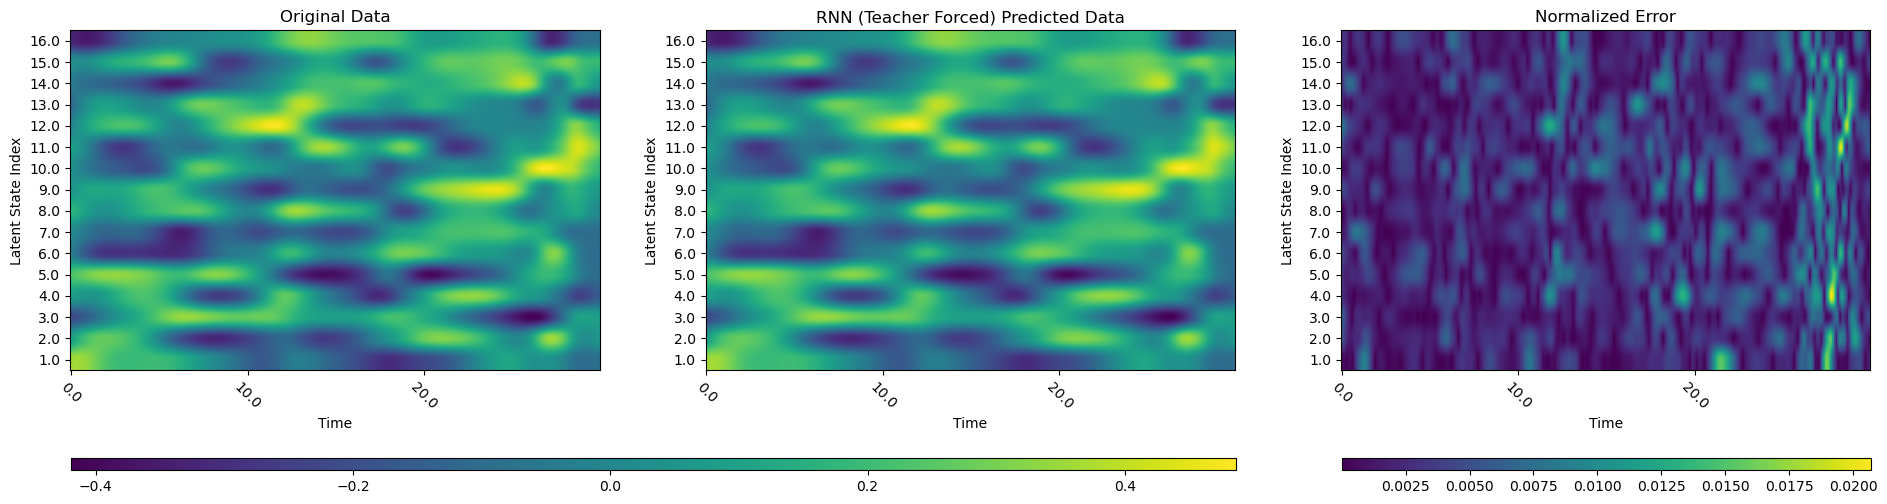

In [39]:
data_type = 'training'
# data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx, 200:200+300]

for layer in rnn_net.ESN_layers:
    layer.reset_states()

prediction = np.array(rnn_net(data_in[data_idx:data_idx+1, :, :], training=False))[:, 200:200+300, :]

for layer in rnn_net.ESN_layers:
    layer.reset_states()

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=10,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [40]:
prediction.shape, data_out.shape

((1, 300, 16), (300, 16))

In [41]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 0


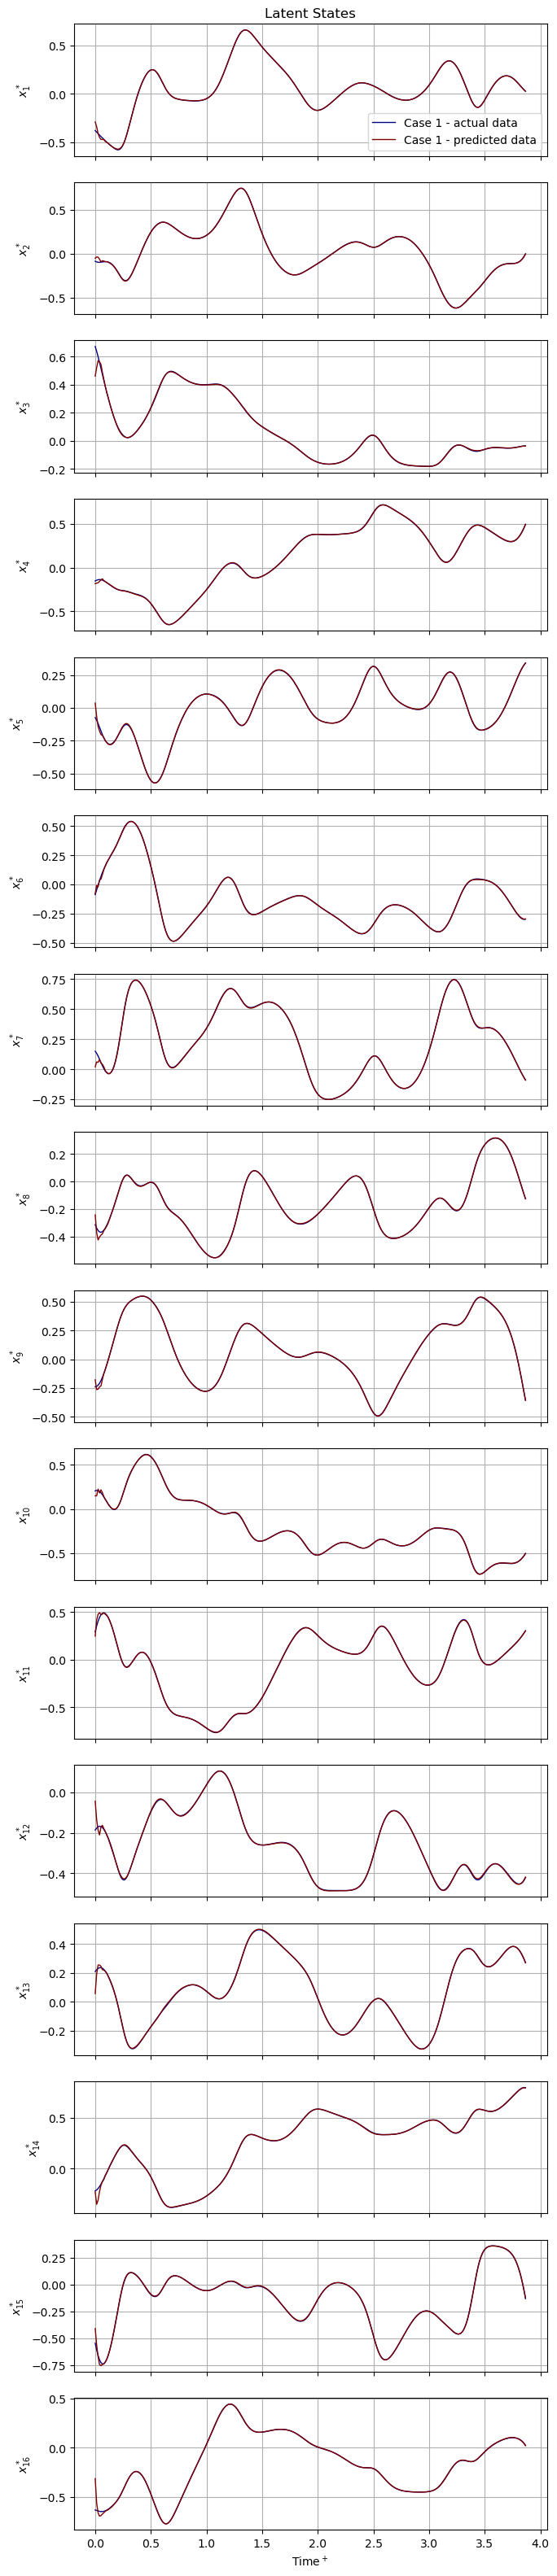


3.8664707312898243


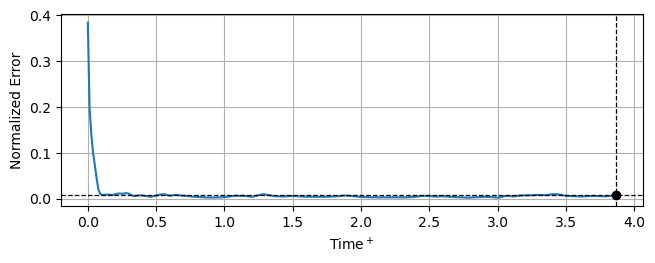

In [42]:
data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx][0:300]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)


for layer in rnn_net.ESN_layers:
    layer.reset_states()

# prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
prediction = np.array(rnn_net(data_in[data_idx:data_idx+1, :, :], training=False))[:, 0:300, :]
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

for layer in rnn_net.ESN_layers:
    layer.reset_states()

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]

ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

# Auto Regressive ESN

In [43]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

In [52]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 15*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 17568
data_.shape : (1, 1237, 16)


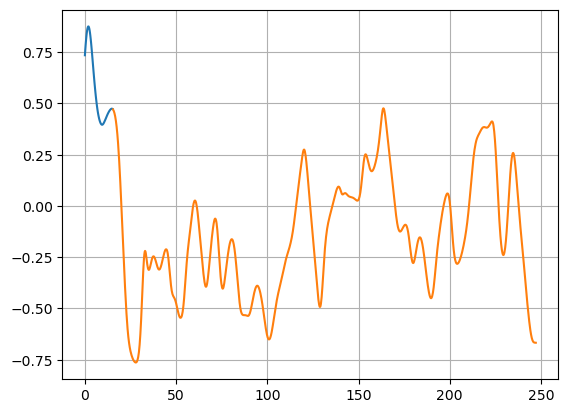

In [57]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [58]:
prediction_lst = []

for layer in rnn_net.ESN_layers:
    layer.reset_states()
    
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :], training=False))[0]

prediction_lst.append(input_preds[-1])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array([[prediction_lst[-1]]])
    output = np.array(rnn_net(data_in_i, training=False))[0, 0]
    prediction_lst.append(output)

In [59]:
prediction_lst = np.stack(prediction_lst)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (77, 16)
prediction_lst.shape : (1160, 16)


2.327641242916951
KE pred 0.7986908 2.7294903 1.8669703
KE true 0.8595796 3.1517677 1.8548054


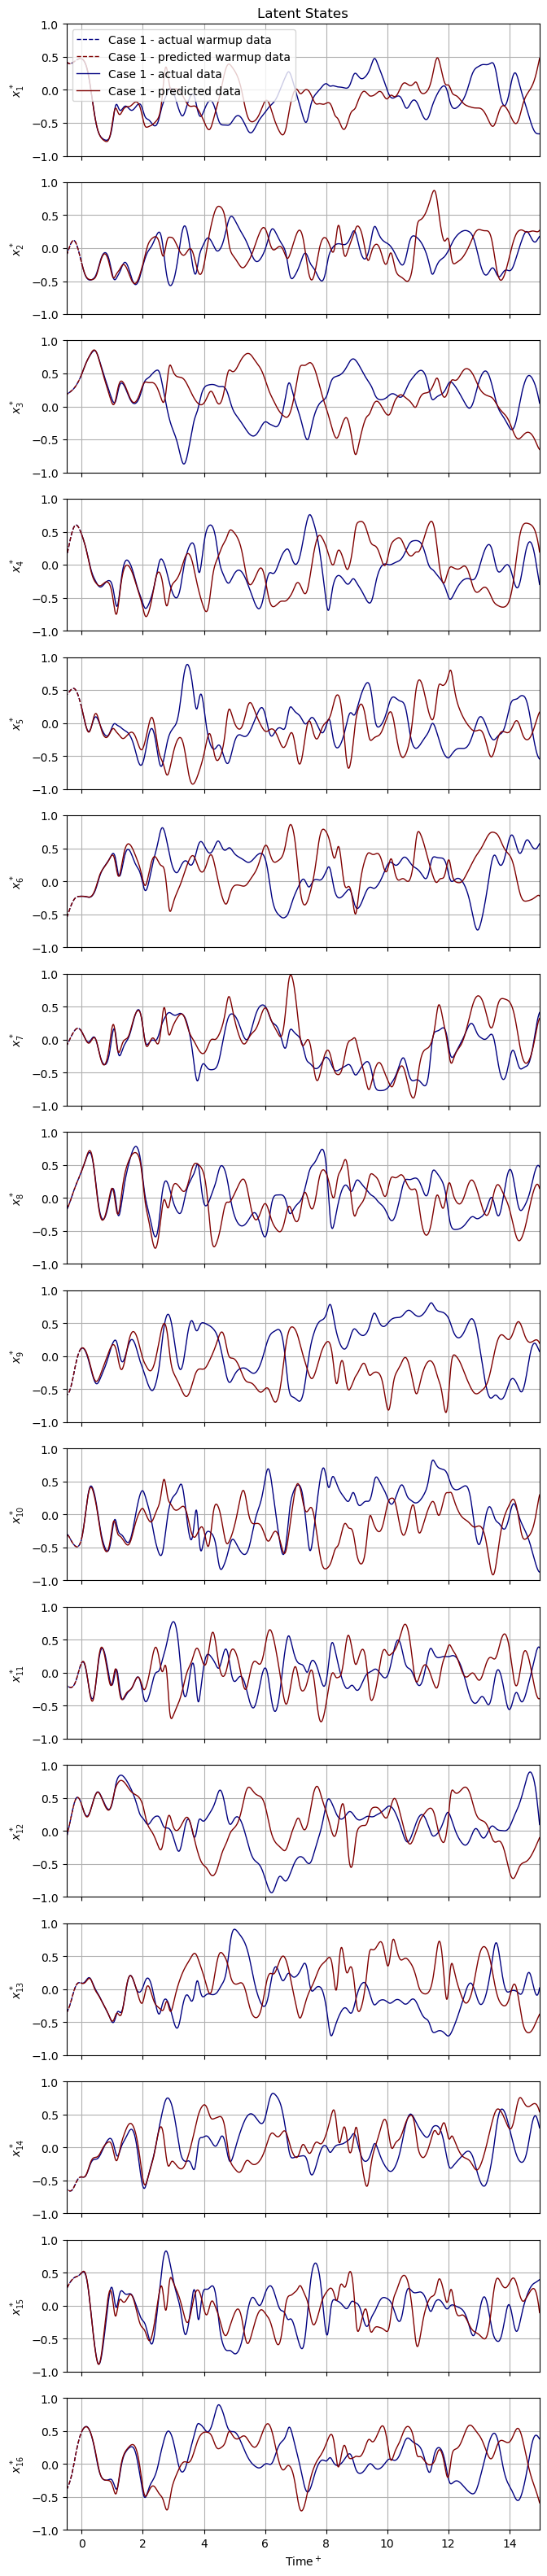

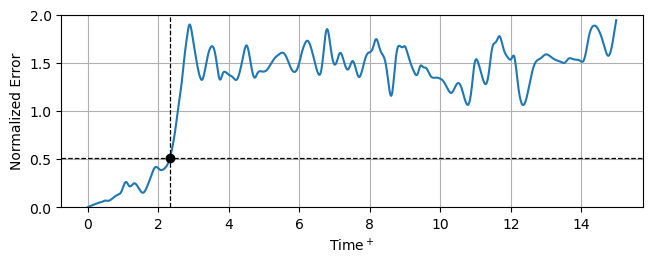

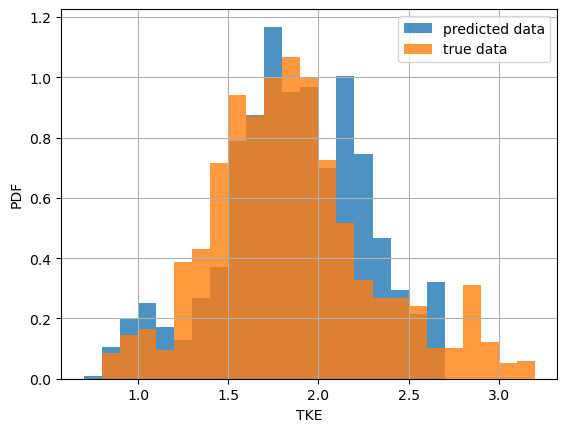

In [68]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)


##### KE histogram #####
KE_true = np.sum(data_[0, num_sample_input_AR:num_sample_input_AR+N, :]**2, axis=-1)
KE_pred = np.sum(prediction_lst**2, axis=-1)

TKE_allspace_pred = KE_pred
TKE_allspace_true = KE_true
density = True

fig, ax = plt.subplots()
print('KE pred', TKE_allspace_pred.min(), TKE_allspace_pred.max(), TKE_allspace_pred.mean())
print('KE true', TKE_allspace_true.min(), TKE_allspace_true.max(), TKE_allspace_true.mean())
bin_width = 0.1 #float(input())# 0.025
bin_begin = 0.0

bin_end_pred = bin_width*np.round((TKE_allspace_pred.max()+0.5*bin_width)//bin_width)
bin_end_true = bin_width*np.round((TKE_allspace_true.max()+0.5*bin_width)//bin_width)

bin_begin_pred = bin_width*int(TKE_allspace_pred.min()//bin_width)
bin_begin_true = bin_width*int(TKE_allspace_true.min()//bin_width)

nbins_pred = int(np.round((bin_end_pred-bin_begin_pred)/bin_width))
nbins_true = int(np.round((bin_end_true-bin_begin_true)/bin_width))

ax.hist(
    TKE_allspace_pred,
    bins=nbins_pred,
    range=[bin_begin_pred, bin_end_pred],
    density=density,
    label='predicted data',
    alpha=0.8)
ax.hist(
    TKE_allspace_true,
    bins=nbins_true,
    range=[bin_begin_true, bin_end_true],
    density=density,
    label='true data',
    alpha=0.8)
ax.legend()

ax.set_xlabel('TKE')
ax.set_ylabel('PDF')

ax.grid(True)

In [61]:
if use_weights_post_dense == True:
    print(rnn_net.postWout.individual_weights)

### Prediction horizon computation

In [69]:
def plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir,
    savefig_fname='pre_ARtraining',
    bin_width=0.05,
    bin_begin=0.0):
    
    fig, ax = plt.subplots()

    ph_mean = np.mean(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    
    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = int(np.round(bin_end/bin_width))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
    ax.axvline(ph_mean, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)')
    ax.set_ylabel('PDF')

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top'
    )

    ax.set_title('nbins = {}'.format(nbins))
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [70]:
def plot_KE_histogram(
        KE_pred, KE_true,
        save_dir,
        savefig_fname='pre_ARtraining-KEhist',
        bin_width=0.05,
        density=True):

    TKE_allspace_pred = KE_pred
    TKE_allspace_true = KE_true

    fig, ax = plt.subplots()
    print('KE pred', TKE_allspace_pred.min(), TKE_allspace_pred.max(), TKE_allspace_pred.mean())
    print('KE true', TKE_allspace_true.min(), TKE_allspace_true.max(), TKE_allspace_true.mean())
    bin_begin = 0.0

    bin_end_pred = bin_width*np.round((TKE_allspace_pred.max()+0.5*bin_width)//bin_width)
    bin_end_true = bin_width*np.round((TKE_allspace_true.max()+0.5*bin_width)//bin_width)

    bin_begin_pred = bin_width*int(TKE_allspace_pred.min()//bin_width)
    bin_begin_true = bin_width*int(TKE_allspace_true.min()//bin_width)

    nbins_pred = int(np.round((bin_end_pred-bin_begin_pred)/bin_width))
    nbins_true = int(np.round((bin_end_true-bin_begin_true)/bin_width))

    ax.hist(
        TKE_allspace_pred,
        bins=nbins_pred,
        range=[bin_begin_pred, bin_end_pred],
        density=density,
        label='predicted data',
        alpha=0.8)
    ax.hist(
        TKE_allspace_true,
        bins=nbins_true,
        range=[bin_begin_true, bin_end_true],
        density=density,
        label='true data',
        alpha=0.8)
    ax.legend()

    ax.set_xlabel('TKE')
    ax.set_ylabel('PDF')

    ax.grid(True)
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [75]:
num_runs = 100
num_runs = np.min([num_runs, maxpossible_num_runs])
print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

savefig_fname = 'pre_ARtraining-'+data_to_consider+'data'
npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])

prediction_horizon_arr = np.empty(shape=num_runs)

KE_pred = np.zeros(shape=(num_runs, num_sample_output_AR))
KE_true = np.zeros_like(KE_pred)

for i in range(num_runs):
    data_idx = data_idx_arr[i]

    # for j in range(len(rnn_data_boundary_idx_arr)):
    #     if data_idx < rnn_data_boundary_idx_arr[j]:
    #         case_idx = j
    #         break
    lyap_time = lyapunov_time_arr[0]

    ### picking the data
    data_ = data_in[0:1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]

    ### doing the predictions
    prediction_lst = []

    for layer in rnn_net.ESN_layers:
        layer.reset_states()

    input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :], training=False))[0]

    prediction_lst.append(input_preds[-1])

    for j in range(1, num_sample_output_AR):
        data_in_j = np.array([[prediction_lst[-1]]])
        output = np.array(rnn_net(data_in_j, training=False))[0, 0]
        prediction_lst.append(output)
    prediction_lst = np.stack(prediction_lst)
    # prediction_lst = invert_normalization(prediction_lst, normalization_arr)
    
    data_out = data_[0, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR, :]
    # data_out = invert_normalization(data_out, normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out[:, :] - prediction_lst[:, :])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

    KE_pred[i, :] = np.sum(prediction_lst**2, axis=-1)
    KE_true[i, :] = np.sum(data_out**2, axis=-1)
    
    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'error_threshold = {}\n'.format(error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname
)

KE_pred = KE_pred.reshape(-1)
KE_true = KE_true.reshape(-1)
plot_KE_histogram(
    KE_pred, KE_true,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname+'-KEhist',
    bin_width=0.05,
)

npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))

num_runs :  100
saved_ESN/ESN_038

error_threshold = 0.5
prediction_horizon : 1.395420925128712, median : 1.3060653640811781
ph_min : 0.6207043314445203, ph_max : 2.6509247488776384
stddev : 0.4453944617592164, IQR : 0.7112237131135128
1st quartile : 1.0345072190742004, 3rd quartile : 1.7457309321877132
KE pred 0.6161918044090271 3.643381118774414 1.7990697479504962
KE true 0.49569129943847656 3.4100446701049805 1.8011333824087834
analysis time : 153.00654077529907 s



KE pred 0.6161918044090271 3.643381118774414 1.7990697479504962
KE true 0.49569129943847656 3.4100446701049805 1.8011333824087834
